In [ ]:
!pip install scvi-tools -U
!pip install scanpy
!pip3 install leidenalg
!pip install git+https://github.com/theislab/scvelo
!pip install cellrank
!pip install harmonypy
#!pip install velocyto

  Cloning https://github.com/theislab/scvelo to /tmp/pip-req-build-qx_rfakk
  Running command git clone -q https://github.com/theislab/scvelo /tmp/pip-req-build-qx_rfakk
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
#import sys
#from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
#import anndata
import seaborn as sns
import scvi
import scvelo as scv
import cellrank as cr
import scanpy.external as sce
#import velocyto as vcy

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#wirka with harmony UMAP and original annotation
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data')
wirka = sc.read_h5ad('wirka_processed.h5ad')


In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data')
transfer_anno = pd.read_csv('wirka_C_scANVI_anno.csv', index_col = 0)
transfer_anno

C_scANVI
AAACGGGTCAGGCAAG-GCA100_T1           MyoFB
AAAGCAATCAACGCTA-GCA100_T1            VSMC
AACCGCGTCACGAAGG-GCA100_T1            Mac1
AACTCCCCAATAGAGT-GCA100_T1           MyoFB
AACTTTCCATATGAGA-GCA100_T1           CD4_1
...                                    ...
TTTGGTTGTTCCACTC-SRR9130253         Plasma
TTTGGTTTCCGCATAA-SRR9130253           Mac1
TTTGGTTTCGCCAGCA-SRR9130253          MyoFB
TTTGTCACACAGCGTC-SRR9130253          MyoFB
TTTGTCAGTCGCGGTT-SRR9130253  Endothelium_2

[55558 rows x 1 columns]

In [ ]:
wirka.obs = wirka.obs.merge(transfer_anno, how = 'left', left_index = True, right_index= True)

In [ ]:
wirka.X = wirka.layers['raw']

In [ ]:
#import wirka velocyto loom files

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/wirka_loom')
files = os.listdir()
files.remove('cache')

loom_files = scv.read(files[0], cache=True)
loom_files.var_names_make_unique()
loom_files.obs['index'] = loom_files.obs.index
loom_files.obs[['accession', 'cell']] = loom_files.obs['index'].str.split(':', expand = True)
loom_files.obs.cell = loom_files.obs.cell.str[:-1]
loom_files.obs.index = loom_files.obs.cell + '-' + loom_files.obs.accession.astype(str)
del loom_files.obs['index']
del loom_files.obs['accession']
del loom_files.obs['cell']


for i in range(1, len(files)):
    temp = scv.read(files[i], cache=True)
    temp.var_names_make_unique()
    temp.obs['index'] = temp.obs.index
    temp.obs[['accession', 'cell']] = temp.obs['index'].str.split(':', expand = True)
    temp.obs.cell = temp.obs.cell.str[:-1]
    temp.obs.index = temp.obs.cell + '-' + temp.obs.accession.astype(str)
    del temp.obs['index']
    del temp.obs['accession']
    del temp.obs['cell']
    loom_files = loom_files.concatenate(temp, index_unique = None)

loom_files_wirka = loom_files

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

In [ ]:
wirka = scv.utils.merge(wirka, loom_files_wirka)

In [ ]:
scv.pp.filter_genes(wirka, min_shared_counts=20)
scv.pp.normalize_per_cell(wirka)
scv.pp.filter_genes_dispersion(wirka, n_top_genes=2000)
scv.pp.log1p(wirka)

Filtered out 27037 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


In [ ]:
wirka.obs.initial_clustering.cat.categories

Index(['FB2', 'Endothelium', 'Macrophage', 'Pericyte1', 'CD4', 'Fibromyocyte',
       'SMC', 'Pericyte2', 'FB1', 'FB3', 'NK', 'Neuron', 'FB4', 'Plasma1',
       'Plasma2', 'Mast_cell', 'Low_qual', '26'],
      dtype='object')

In [ ]:
temp = wirka[wirka.obs.initial_clustering.isin(['FB1', 'FB2',  'Fibromyocyte', 'SMC']),:]

In [ ]:
scv.pp.neighbors(temp, n_neighbors=30, n_pcs=None)
scv.pp.moments(temp, n_pcs=30, n_neighbors=30)

computing neighbors


Trying to set attribute `.uns` of view, copying.


    finished (0:00:42) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
scv.tl.recover_dynamics(temp, n_jobs=8)


recovering dynamics (using 4/4 cores)


  0%|          | 0/421 [00:00<?, ?gene/s]

    finished (0:03:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [ ]:
scv.tl.velocity(temp, mode="dynamical")
scv.tl.velocity_graph(temp)

computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/4 cores)


  0%|          | 0/9987 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:
temp = temp[temp.obs.C_scANVI.isin(['VSMC', 'Transitional', 'MyoFB']),:]

In [ ]:
new_colors = np.array(temp.uns['C_scANVI_colors'])

new_colors[[2]] = '#2c7c94'  # VSMC_tissue
new_colors[[1]] = '#343c24'  # Transitional_tissue
new_colors[[0]] = '#fbe45b'  # MyoFB_tissue

temp.uns['C_scANVI_colors'] = new_colors

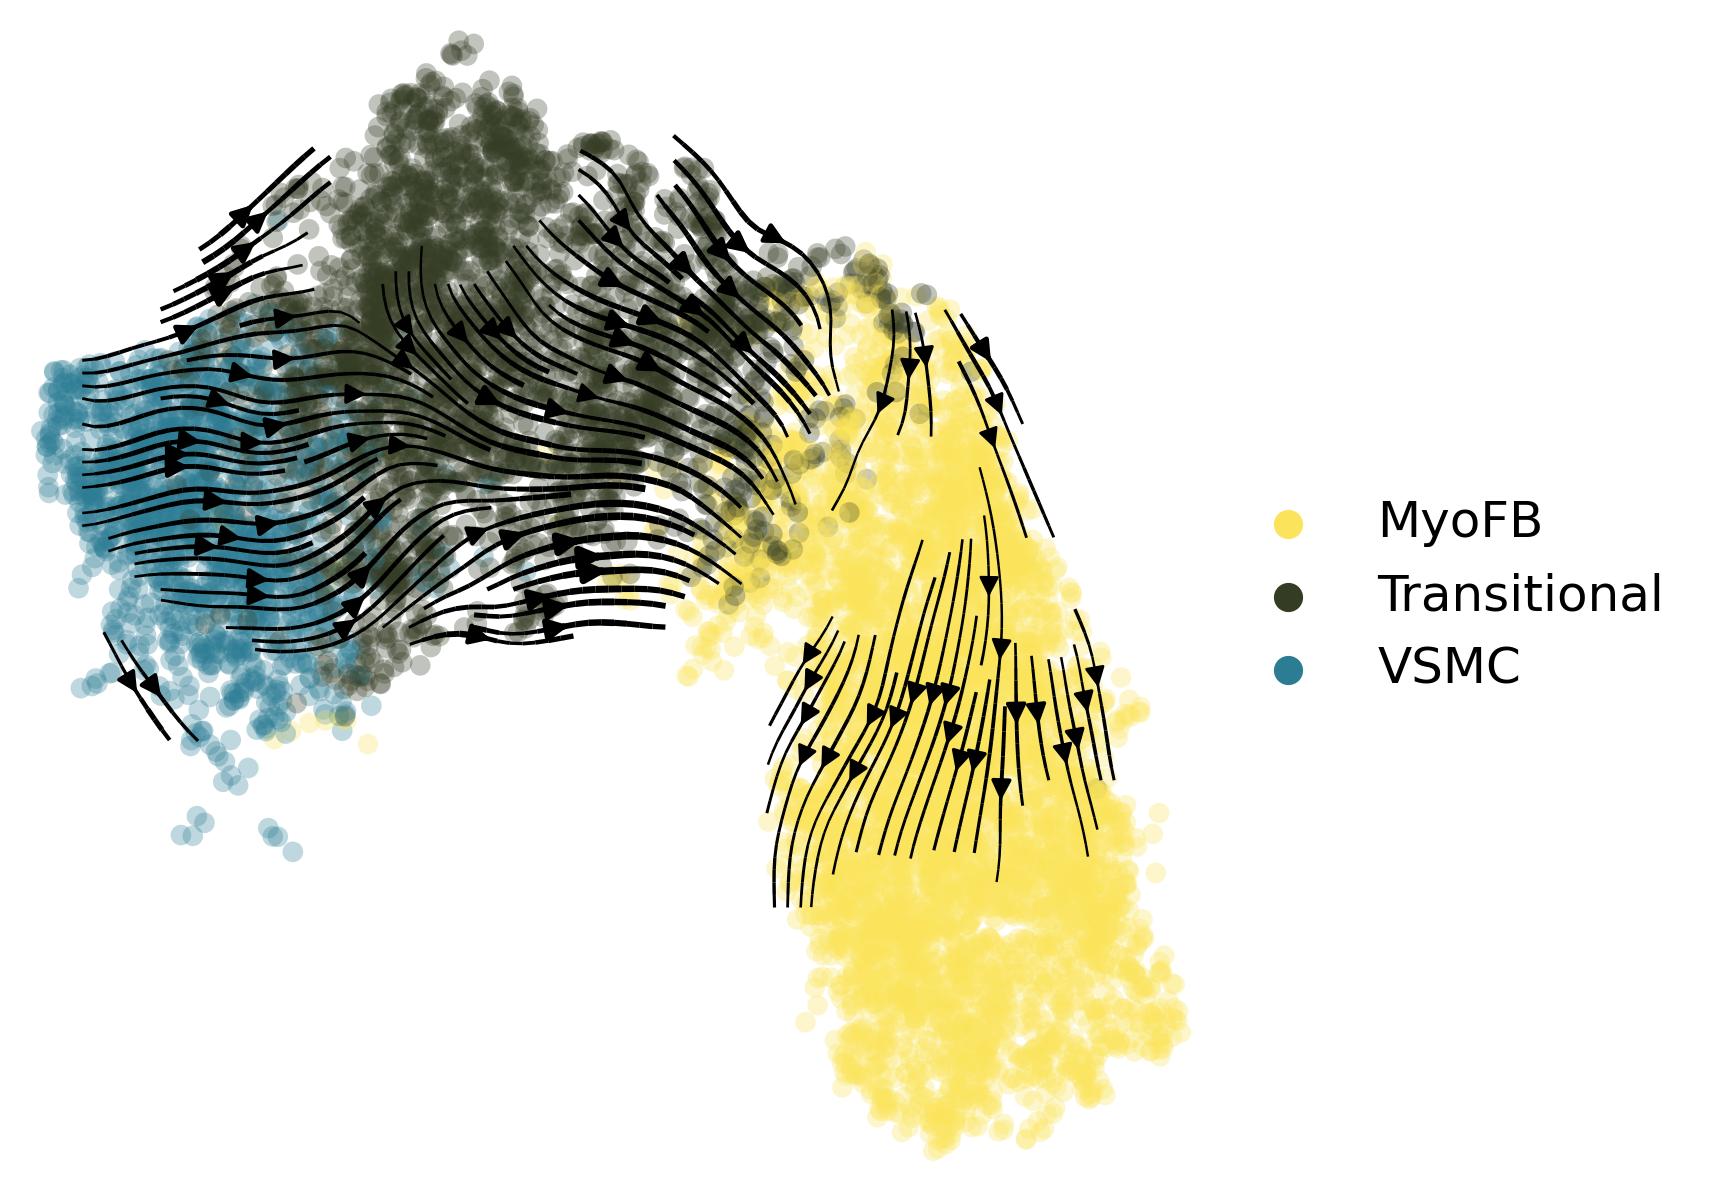

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')


scv.pl.velocity_embedding_stream(temp, basis="X_umap", 
                                 legend_fontsize=12, 
                                 title="", 
                                 smooth=0.8, 
                                 min_mass=4,
                                 density = 3, 
                                 save = 'wirka_velocity_plot_C_scANVI_annotation.png',
                                 color = 'C_scANVI', 
                                 legend_loc = 'right',
                                 dpi = 300
                                 )

saving figure to file ./figures/scvelo_wirka_velocity_plot_ACTA2.png


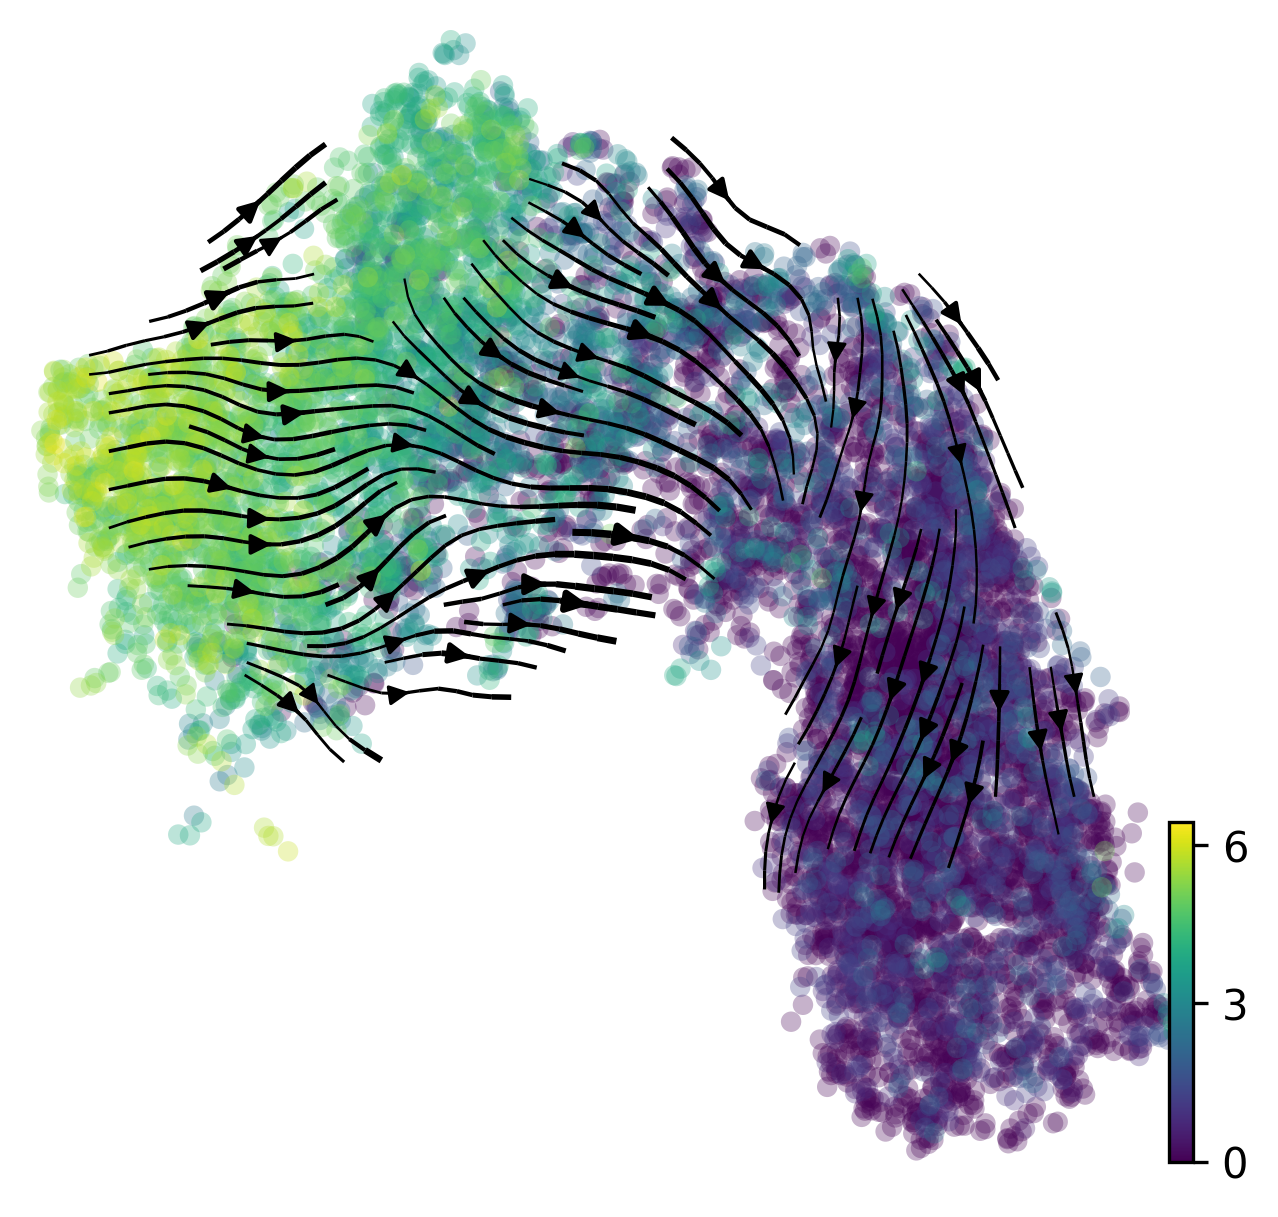

In [ ]:
scv.pl.velocity_embedding_stream(temp, basis="X_umap", 
                                 legend_fontsize=12, 
                                 title="", 
                                 smooth=0.8, 
                                 min_mass=4, 
                                 color = 'ACTA2', 
                                 colorbar = True,
                                 legend_loc = 'right',
                                 dpi = 300,
                                 save = 'wirka_velocity_plot_ACTA2.png')

saving figure to file ./figures/scvelo_wirka_velocity_plot_DCN.png


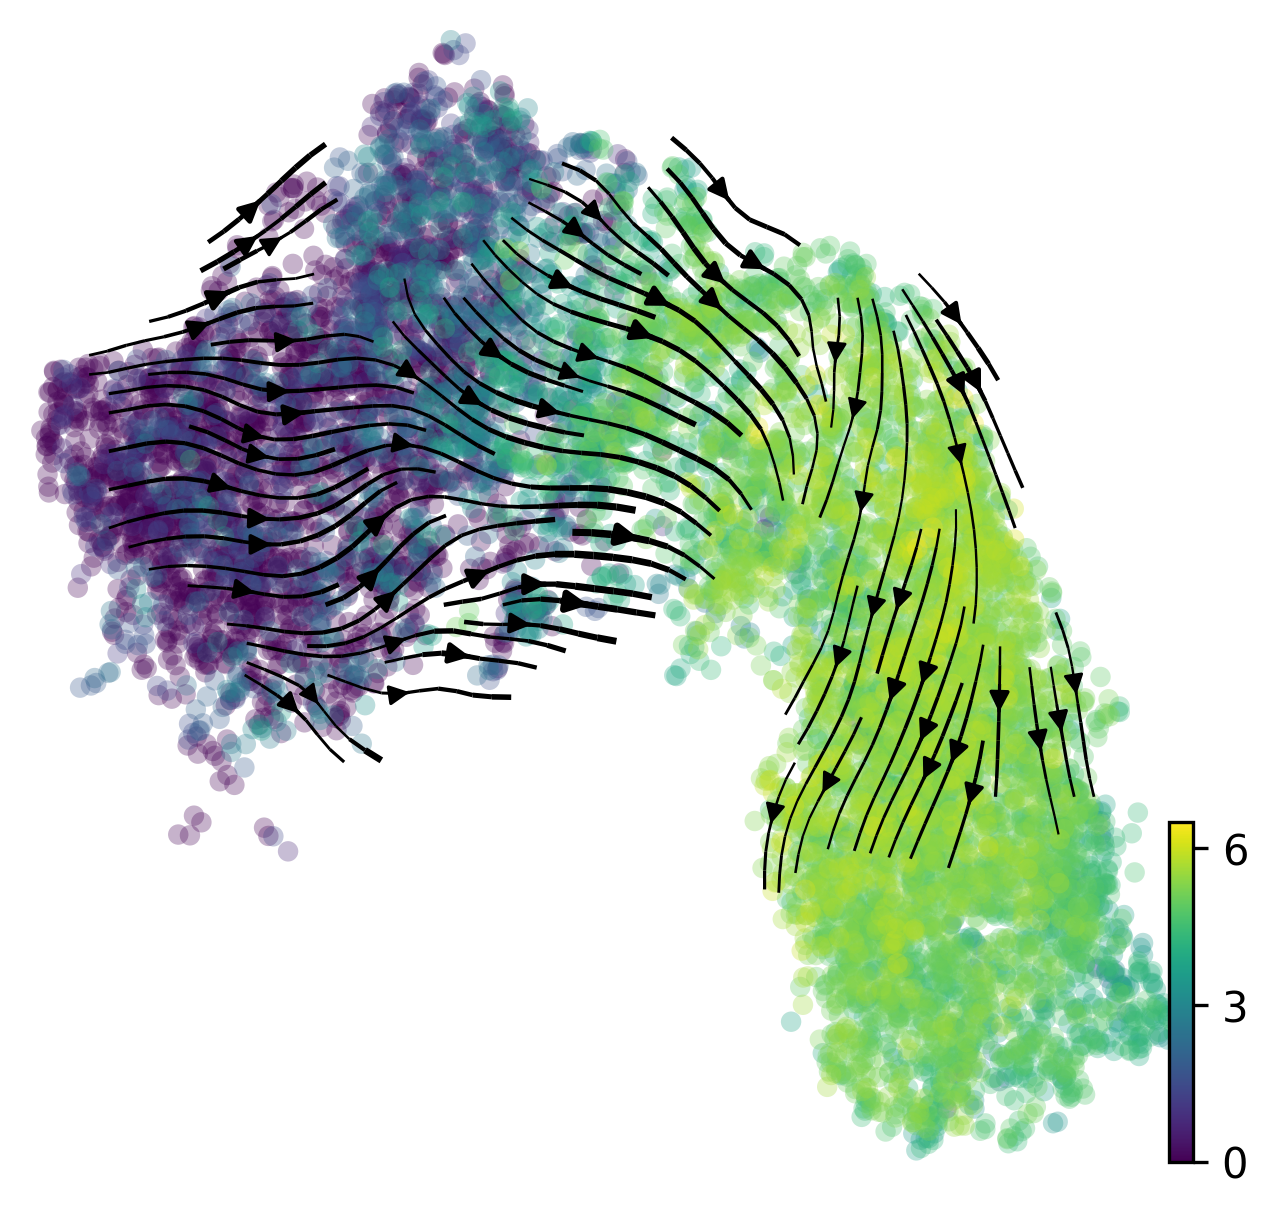

In [ ]:
scv.pl.velocity_embedding_stream(temp, basis="X_umap", 
                                 legend_fontsize=12, 
                                 title="", 
                                 smooth=0.8, 
                                 min_mass=4, 
                                 color = 'DCN', 
                                  colorbar = True,
                                 legend_loc = 'right',
                                 dpi = 300,
                                save = 'wirka_velocity_plot_DCN.png')

saving figure to file ./figures/scvelo_wirka_velocity_plot_DKK3.png


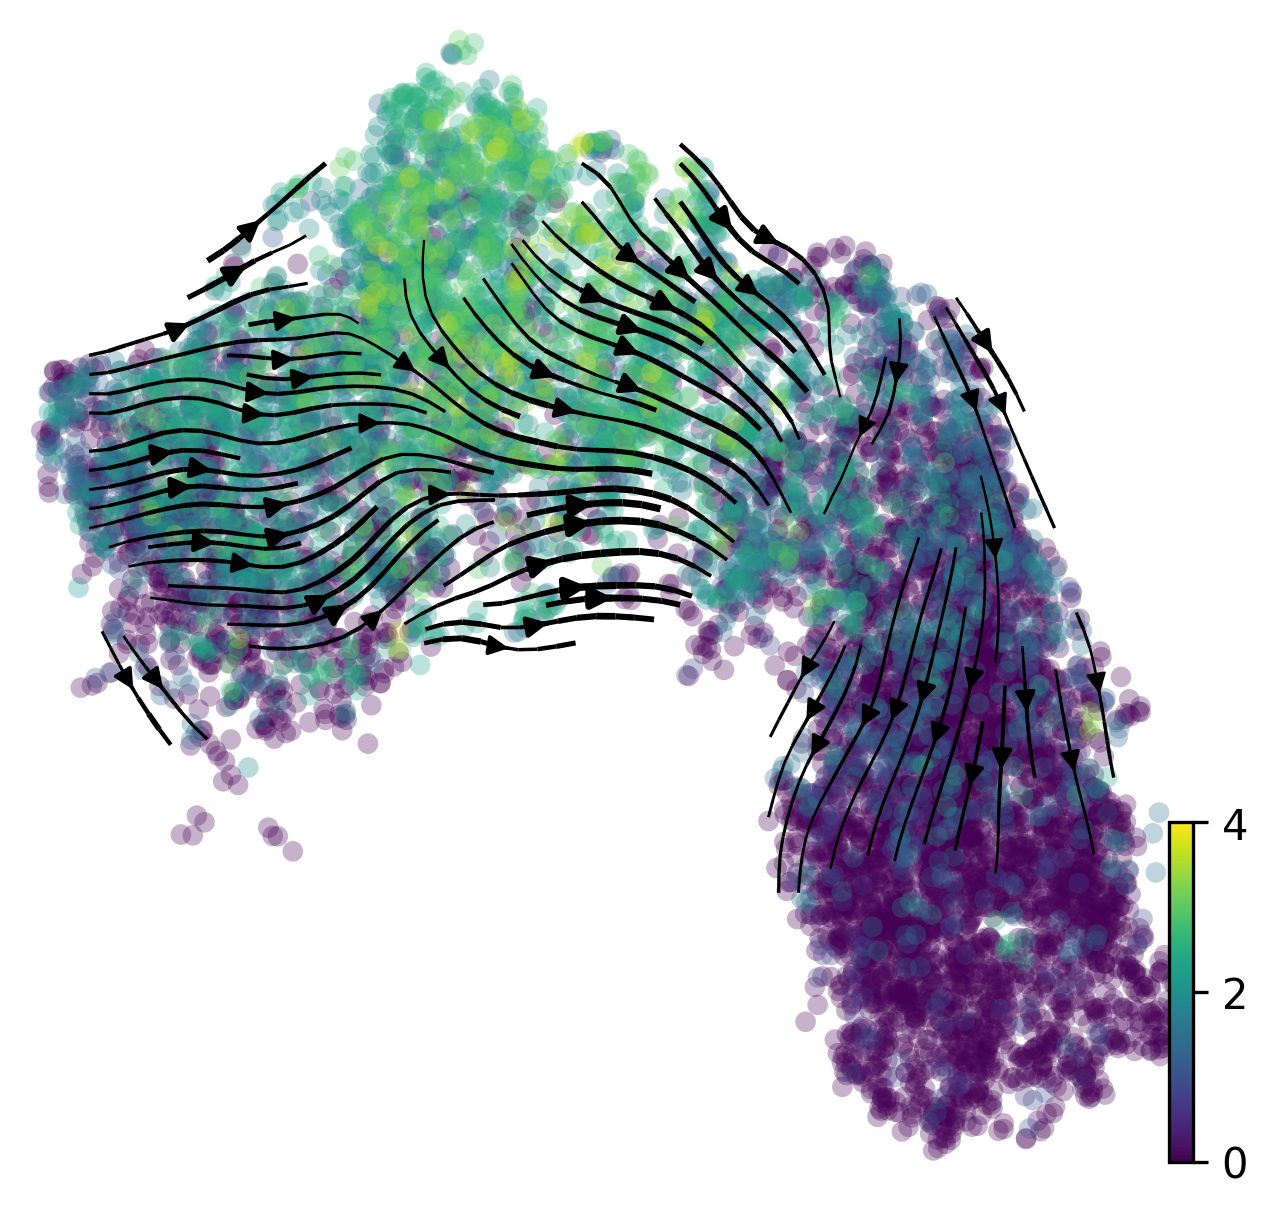

In [ ]:
scv.pl.velocity_embedding_stream(temp, basis="X_umap", 
                                 legend_fontsize=12, 
                                 title="", 
                                 smooth=0.8, 
                                 min_mass=4, 
                                 color = 'DKK3', 
                                  colorbar = True,
                                 legend_loc = 'right',
                                 dpi = 300,
                                save = 'wirka_velocity_plot_DKK3.png')